<a href="https://colab.research.google.com/github/OleksiiLatypov/House_Prices/blob/main/imrpove_feature_version_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'house-prices-advanced-regression-techniques:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F5407%2F868283%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240911%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240911T202213Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8ad9fa6968769a5945a992cba0d144ead3a1636aed894fc66c8f7dfc590723d2a652fe2d2543fb09e1e8c78e1dd3a6750ff12e3ec75ff6784619f9a8800f32fbcde3117b70a608298761f71ce8ffa5a81f568571e38fdca0bc88aa454ad96640cde0f58a702a4b167673945da1e9f100d405c553c6b7e409afee7c080ccd7d40fb05aec5ec2086a5d02a8d971115bf0c186f3d577f37a7d5e62315c794bc869908f66efda4ba80c6f3e9e80969595e7afd09724ddd50fa848f811e583227d6db358b2f12eda1616b699c73ffa0878882d20671fe66d564c7c2b8568157e3ddcb2fec26169de3b7e76ebf61d19f8243a1bef24ef8fd3cff4d0351df29c5b20238'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [ ]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [ ]:
train.shape

(1460, 81)

In [ ]:
test.shape

(1459, 80)

In [ ]:
GrLivArea_outlier = train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index
GrLivArea_outlier

Index([523, 1298], dtype='int64')

In [ ]:
train = train.drop(GrLivArea_outlier)

In [ ]:
train.shape

In [ ]:
df = pd.concat([train, test], axis=0, ignore_index=True)
df.shape

(2919, 81)

In [ ]:
df = df.drop('Id', axis=1)

In [ ]:
# df_cat = df.select_dtypes('object')
df_cat = df.select_dtypes('object')
missing = (100 * (df_cat.isna().sum())/len(df_cat)).sort_values(ascending=False)
large_missing_vals = [col for col in missing.index if missing[col] > 20]
large_missing_vals

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu']

In [ ]:
# df_cat = df.select_dtypes('object')
df_num = df.select_dtypes('number')
missing_num = (100 * (df_num.isna().sum())/len(df_num)).sort_values(ascending=False)
large_missing_num_vals = [col for col in missing_num.index if missing_num[col] > 20]
large_missing_num_vals

['SalePrice']

In [ ]:
large_missing_num_vals.remove('SalePrice')
large_missing_num_vals

[]

In [ ]:
missing_values = 100 * (df.isna().sum()/df.shape[0])
missing_data = pd.DataFrame({'Perrcentage of Missing Values': missing_values.sort_values(ascending=False)})
missing_data.head(15)

,Perrcentage of Missing Values
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
MasVnrType,60.500171
SalePrice,49.982871
FireplaceQu,48.646797
LotFrontage,16.649538
GarageFinish,5.447071
GarageQual,5.447071


In [ ]:
columns_to_drop = large_missing_vals+large_missing_num_vals
columns_to_drop

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu']

In [ ]:
df = df.drop(columns_to_drop, axis=1)

In [ ]:
df.shape

(2919, 74)

In [ ]:
#important_cat = ["MSZoning", "Utilities","BldgType","Heating","KitchenQual","SaleCondition","LandSlope"]

In [ ]:
df_cat_cols = df.select_dtypes('object')

In [ ]:
df['GarageYrBlt'].isna().sum()

159

In [ ]:
garage_cat_columns = [col for col in df_cat_cols.columns if col.startswith('Garage')]
#garage_cat_columns
for col in garage_cat_columns:
    df.loc[:, col] = df.loc[:, col].fillna('NA')

In [ ]:
df = df.drop('GarageYrBlt', axis=1)

In [ ]:
bsmt_columns = [col for col in df.columns if col.startswith('Bsmt')]
# df[bsmt_columns].isna().sum()
# df[bsmt_columns].info()
basement = ['BsmtFinType2', 'BsmtFinType1', 'BsmtExposure', 'BsmtCond', 'BsmtQual']
for col in basement:
    df.loc[:, col] = df.loc[:, col].fillna('NA')


In [ ]:
bsmt_columns

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'BsmtFullBath',
 'BsmtHalfBath']

In [ ]:
numeric_columns =df.select_dtypes(include=['number'])
for col in numeric_columns:
    df.loc[:, col] = df.loc[:, col].fillna(df.loc[:, col].mean())

In [ ]:
categorical_columns = df.select_dtypes(include=['object'])
for col in categorical_columns:
    df.loc[:, col] = df.loc[:, col].fillna(df.loc[:, col].mode()[0])

In [ ]:
# for col in df_cat_cols.columns:
#     df[col] = df[col].fillna(df[col].mode()[0])

In [ ]:
# for col in df_num.columns:
#     df[col] = df[col].fillna(df[col].mean())

In [ ]:
df[garage_cat_columns].value_counts()

GarageType  GarageFinish  GarageQual  GarageCond
Attchd      RFn           TA          TA            701
Detchd      Unf           TA          TA            579
Attchd      Fin           TA          TA            548
            Unf           TA          TA            430
NA          NA            NA          NA            157
BuiltIn     Fin           TA          TA            126
Detchd      Unf           Fa          TA             53
BuiltIn     RFn           TA          TA             46
Detchd      Unf           Fa          Fa             36
            RFn           TA          TA             34
            Unf           TA          Fa             29
            Fin           TA          TA             20
CarPort     Unf           TA          TA             13
Basment     Unf           TA          TA             13
2Types      Unf           TA          TA             13
Attchd      Unf           Fa          TA             13
Basment     Fin           TA          TA             10

In [ ]:
df.isna().sum().sort_values(ascending=False)

MSSubClass      0
HeatingQC       0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
               ..
ExterQual       0
MasVnrArea      0
Exterior2nd     0
Exterior1st     0
SalePrice       0
Length: 73, dtype: int64

In [ ]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000.0


In [ ]:
important_cat = ["HeatingQC","KitchenQual", "ExterQual"]

#cat_columns = dataset[important_cat]
#dataset = self.fill_miss_cat(dataset, important_cat)
heatingqc_mapping = {
    'Ex': 4,
    'Gd': 3,
    'TA': 2,
    'Fa': 1,
    'Po': 0
}
# Apply the mapping to the HeatingQC column
df['HeatingQC'] = df['HeatingQC'].map(heatingqc_mapping)
#print(f"HeatingQC: {df['HeatingQC'].corr(dataset['SalePrice'])}")
kitchenqual_mapping = {
    'Ex': 4,
    'Gd': 3,
    'TA': 2,
    'Fa': 1,
    'Po': 0
}
# Apply the mapping to the KitchenQual column
df['KitchenQual'] = df['KitchenQual'].map(kitchenqual_mapping)
#print(f"KitchenQC: {dataset['KitchenQual'].corr(dataset['SalePrice'])}")


cond_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
#print(dataset['ExterQual'].value_counts())
df['ExterQual'] = df['ExterQual'].map(cond_mapping)

In [ ]:
df = df.drop('Utilities', axis=1)

In [ ]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

In [ ]:
df.shape

(2919, 73)

In [ ]:
df = pd.get_dummies(df, dtype='int')
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
train_df = df.iloc[:1460, :]
train_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1456,20,85.0,13175,6,6,1978,1988,119.0,790.0,163.0,...,0,0,0,1,0,0,0,0,1,0
1457,70,66.0,9042,7,9,1941,2006,0.0,275.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1458,20,68.0,9717,5,6,1950,1996,0.0,49.0,1029.0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
test_df = df.iloc[1460:, :]
test_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,0,0,0,1,0,0,0,0,1,0
1461,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1462,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1463,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1464,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2915,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,...,0,0,0,1,1,0,0,0,0,0
2916,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,...,0,0,0,1,1,0,0,0,0,0
2917,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,...,0,0,0,1,0,0,0,0,1,0


<Axes: >

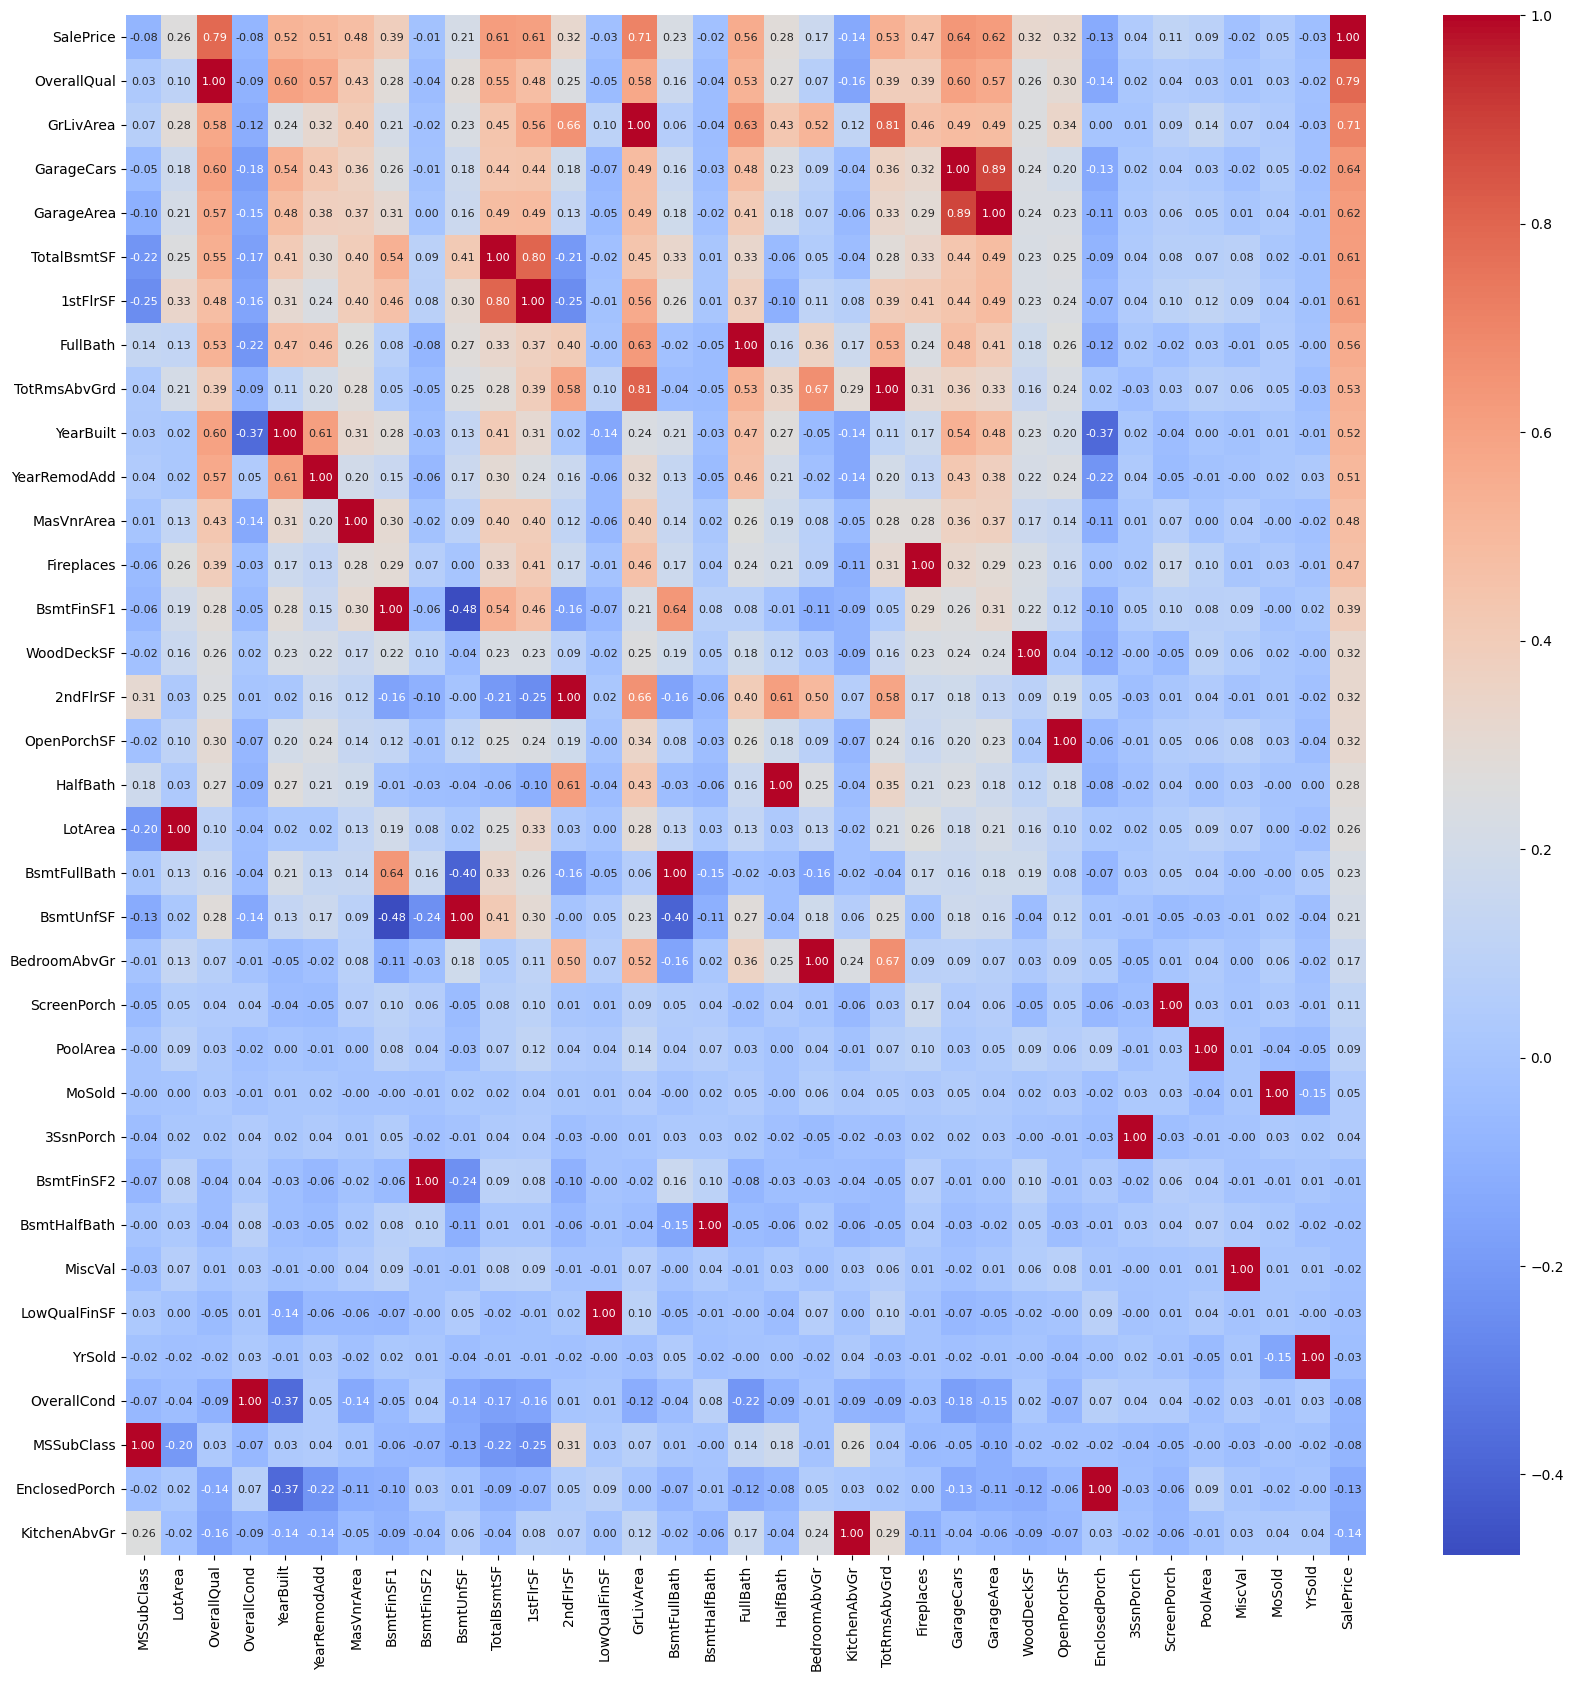

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))
#num_cols = train.select_dtypes('number')
correlation_matrix = numeric_columns.corr().sort_values(by='SalePrice', ascending=False)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='0.2f', annot_kws={'size': 8})

In [ ]:
col_to_drop = ['1stFlrSF','GarageArea','TotRmsAbvGrd']
train_df = train_df.drop(col_to_drop, axis=1)
test_df = test_df.drop(col_to_drop, axis=1)

In [ ]:
X = train_df.drop('SalePrice', axis=1)
y = np.log(train_df['SalePrice'])

In [ ]:
# to_drop = ['GarageYrBlt','1stFlrSF','GarageArea','TotRmsAbvGrd']
# X = X.drop(to_drop, axis=1)
X.shape

(1460, 270)

In [ ]:
# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler()
# X = scaler.fit_transform(X)


In [ ]:
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

# Get feature importances
feature_importances = clf_catboost.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary mapping feature names to importances
feature_importance_dict = dict(zip(feature_names, feature_importances))
# Sort the dictionary by importance (optional)
sorted_feature_importance_dict = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

# Print or access the feature importances
res = []
print("Feature Importances:")
for feature, importance in sorted_feature_importance_dict.items():
    print(f"{feature}: {importance}")
    if importance > 0:
        res.append(feature)
print(res)


Feature Importances:
TotalSF: 23.598770023887294
OverallQual: 16.23795390069306
YearBuilt: 4.761595747010008
GrLivArea: 4.724655669049843
YearRemodAdd: 3.53077573882267
GarageCars: 3.301327137937047
LotArea: 3.0655991592387917
OverallCond: 2.8413119032746894
Fireplaces: 2.825963990458258
BsmtFinSF1: 2.362418222097399
TotalBsmtSF: 1.5784920881382873
CentralAir_Y: 1.1264929983968222
CentralAir_N: 1.0432625261215427
HalfBath: 1.0070761374090083
LotFrontage: 0.9430805693823662
KitchenQual_Ex: 0.8891158323530124
BsmtUnfSF: 0.7559886560454582
FullBath: 0.7338534068615001
MSZoning_C (all): 0.715188300643933
ExterQual_TA: 0.686731133885006
BsmtQual_Gd: 0.669476012623578
BsmtQual_TA: 0.6683263329656517
WoodDeckSF: 0.6507781108835867
SaleCondition_Abnorml: 0.6290502800003861
KitchenQual_TA: 0.605982473414981
MSZoning_RL: 0.601973153911606
OpenPorchSF: 0.5523705068477097
GarageCond_TA: 0.544676432582228
YrSold: 0.5263350282699779
BsmtFullBath: 0.5203011991838622
Neighborhood_Crawfor: 0.5072059353

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# from sklearn.linear_model import LinearRegression

# lr = LinearRegression()
# lr.fit(X_train, y_train)
# lr_prediction = lr.predict(X_test)

In [ ]:
# print('MAE: ', mean_absolute_error(y_test, lr_prediction))
# print('MSE: ', mean_squared_error(y_test, lr_prediction))
# print('R2 score', r2_score(y_test, lr_prediction))
# print('RMSE:', np.sqrt(mean_squared_error(y_test, lr_prediction)))

In [ ]:
# from sklearn.model_selection import train_test_split
# from catboost import CatBoostRegressor


# # Define CatBoostRegressor model
# clf_catboost = CatBoostRegressor(iterations=1000,
#                                  learning_rate=0.1,
#                                  depth=4,
#                                  l2_leaf_reg=2,
#                                  loss_function='RMSE',
#                                  random_seed=0)

# # Train the model
# clf_catboost.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

# # Predict on test data
# catboost_pred = clf_catboost.predict(X_test)

**WITH UTILITIES**

In [ ]:
# #for test split 0.3 is the best !!!
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from catboost import CatBoostRegressor


clf_catboost = CatBoostRegressor(iterations=700,
                                 learning_rate=0.091,
                                 depth=6,
                                 l2_leaf_reg=3,
                                 border_count=254,
                                 #early_stopping_rounds = 200,
                                 verbose=0)  # verbose=0 to suppress output during cross-validation

pipeline = Pipeline([
    #('scaler', MinMaxScaler()),
    ('model', clf_catboost)
])
# Define k-fold cross-validation
n_splits = 5  # number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation and evaluate RMSE
rmse_scores = -cross_val_score(pipeline, X, y, scoring='neg_root_mean_squared_error', cv=kf)

# Calculate mean and standard deviation of RMSE
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Standard Deviation of RMSE: {std_rmse:.4f}")

pipeline.fit(X, y)

Mean RMSE: 0.1251
Standard Deviation of RMSE: 0.0160


Pipeline(steps=[('model',
                 <catboost.core.CatBoostRegressor object at 0x7842c330eda0>)])

In [ ]:
# #for test split 0.3 is the best !!!
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from catboost import CatBoostRegressor


clf_catboost = CatBoostRegressor(iterations=1500,
                                 learning_rate=0.03,
                                 depth=6,
                                 l2_leaf_reg=3,
                                 border_count=42,
                                 #early_stopping_rounds = 300,
                                 verbose=0)  # verbose=0 to suppress output during cross-validation

pipeline = Pipeline([
    #('scaler', MinMaxScaler()),
    ('model', clf_catboost)
])
# Define k-fold cross-validation
n_splits = 5  # number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation and evaluate RMSE
rmse_scores = -cross_val_score(pipeline, X, y, scoring='neg_root_mean_squared_error', cv=kf)

# Calculate mean and standard deviation of RMSE
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Standard Deviation of RMSE: {std_rmse:.4f}")

pipeline.fit(X, y)

Mean RMSE: 0.1207
Standard Deviation of RMSE: 0.0152


Pipeline(steps=[('model',
                 <catboost.core.CatBoostRegressor object at 0x7842c2909c30>)])

In [ ]:
# importances = clf_catboost.feature_importances_

# # Get feature names (assuming you have them)
# feature_names = np.array(X.columns) if hasattr(X, 'columns') else np.arange(X.shape[1])

# # Sort feature importances in descending order
# indices = np.argsort(importances)[::-1]

# # Print feature importance scores
# print("Feature ranking:")
# for f in range(X.shape[1]):
#     print(f"{f + 1}. Feature {indices[f]}: {importances[indices[f]]:.4f}")


Feature ranking:
1. Feature 32: 23.5988
2. Feature 3: 16.2380
3. Feature 5: 4.7616
4. Feature 14: 4.7247
5. Feature 6: 3.5308
6. Feature 22: 3.3013
7. Feature 2: 3.0656
8. Feature 4: 2.8413
9. Feature 21: 2.8260
10. Feature 8: 2.3624
11. Feature 11: 1.5785
12. Feature 212: 1.1265
13. Feature 211: 1.0433
14. Feature 18: 1.0071
15. Feature 1: 0.9431
16. Feature 218: 0.8891
17. Feature 10: 0.7560
18. Feature 17: 0.7339
19. Feature 33: 0.7152
20. Feature 159: 0.6867
21. Feature 173: 0.6695
22. Feature 175: 0.6683
23. Feature 23: 0.6508
24. Feature 264: 0.6291
25. Feature 221: 0.6060
26. Feature 36: 0.6020
27. Feature 24: 0.5524
28. Feature 251: 0.5447
29. Feature 31: 0.5263
30. Feature 15: 0.5203
31. Feature 62: 0.5072
32. Feature 30: 0.5072
33. Feature 7: 0.5052
34. Feature 245: 0.4848
35. Feature 12: 0.4754
36. Feature 230: 0.4649
37. Feature 182: 0.4487
38. Feature 171: 0.4145
39. Feature 238: 0.4049
40. Feature 63: 0.4002
41. Feature 19: 0.3987
42. Feature 37: 0.3851
43. Feature 254: 0

In [ ]:
perm_importance = permutation_importance(pipeline, X, y, n_repeats=10, random_state=42, scoring='neg_root_mean_squared_error')

# Get feature names (assuming X is a DataFrame, otherwise use np.arange(X.shape[1]))
feature_names = X.columns if hasattr(X, 'columns') else np.arange(X.shape[1])

# Get the mean importance and sort it
sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]
sorted_importances = perm_importance.importances_mean[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Print sorted feature importance scores
print("Feature ranking:")
for i, (feature, importance) in enumerate(zip(sorted_feature_names, sorted_importances)):
    print(f"{i + 1}. Feature '{feature}': Importance = {importance:.4f}")

Feature ranking:
1. Feature 'TotalSF': Importance = 0.1322
2. Feature 'OverallQual': Importance = 0.0844
3. Feature 'YearBuilt': Importance = 0.0330
4. Feature 'GrLivArea': Importance = 0.0320
5. Feature 'OverallCond': Importance = 0.0268
6. Feature 'LotArea': Importance = 0.0237
7. Feature 'YearRemodAdd': Importance = 0.0211
8. Feature 'GarageCars': Importance = 0.0190
9. Feature 'BsmtFinSF1': Importance = 0.0116
10. Feature 'Fireplaces': Importance = 0.0114
11. Feature 'MSZoning_C (all)': Importance = 0.0108
12. Feature 'BsmtUnfSF': Importance = 0.0077
13. Feature 'Neighborhood_Crawfor': Importance = 0.0070
14. Feature 'TotalBsmtSF': Importance = 0.0069
15. Feature 'SaleCondition_Abnorml': Importance = 0.0062
16. Feature 'LotFrontage': Importance = 0.0061
17. Feature 'MoSold': Importance = 0.0058
18. Feature 'YrSold': Importance = 0.0055
19. Feature 'WoodDeckSF': Importance = 0.0051
20. Feature 'MasVnrArea': Importance = 0.0042
21. Feature 'OpenPorchSF': Importance = 0.0037
22. Featu

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestRegressor(n_estimators=100,
                                  random_state=0).fit(train_X, train_y)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

2024-09-11 20:18:33.863757: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 20:18:33.863888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 20:18:34.045850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Weight,Feature
0.3896 ± 0.0328,TotalSF
0.2233 ± 0.0365,OverallQual
0.0156 ± 0.0021,YearBuilt
0.0111 ± 0.0017,GarageCars
0.0104 ± 0.0029,YearRemodAdd
0.0089 ± 0.0011,OverallCond
0.0068 ± 0.0037,LotArea
0.0066 ± 0.0017,BsmtFinSF1
0.0056 ± 0.0020,GrLivArea
0.0055 ± 0.0035,BsmtUnfSF


In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1, random_state=42)  # Adjust alpha to control regularization strength

# Fit the model
lasso.fit(train_X, train_y)

# Get feature importances (absolute values of coefficients)
importances = np.abs(lasso.coef_)

# Get feature names (assuming X is a DataFrame)
feature_names = X.columns if hasattr(X, 'columns') else np.arange(X.shape[1])

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Print sorted feature importance scores
print("Feature ranking:")
for i, (feature, importance) in enumerate(zip(sorted_feature_names, sorted_importances)):
    print(f"{i + 1}. Feature '{feature}': Importance = {importance:.4f}")

Feature ranking:
1. Feature 'YearBuilt': Importance = 0.0038
2. Feature 'YearRemodAdd': Importance = 0.0037
3. Feature 'PoolArea': Importance = 0.0007
4. Feature 'MSSubClass': Importance = 0.0006
5. Feature 'ScreenPorch': Importance = 0.0006
6. Feature 'GrLivArea': Importance = 0.0003
7. Feature 'EnclosedPorch': Importance = 0.0003
8. Feature 'WoodDeckSF': Importance = 0.0002
9. Feature '3SsnPorch': Importance = 0.0001
10. Feature 'TotalBsmtSF': Importance = 0.0001
11. Feature 'MasVnrArea': Importance = 0.0001
12. Feature 'TotalSF': Importance = 0.0001
13. Feature 'OpenPorchSF': Importance = 0.0000
14. Feature 'BsmtFinSF1': Importance = 0.0000
15. Feature '2ndFlrSF': Importance = 0.0000
16. Feature 'MiscVal': Importance = 0.0000
17. Feature 'BsmtUnfSF': Importance = 0.0000
18. Feature 'LotArea': Importance = 0.0000
19. Feature 'Condition2_Norm': Importance = 0.0000
20. Feature 'BldgType_TwnhsE': Importance = 0.0000
21. Feature 'Condition2_Feedr': Importance = 0.0000
22. Feature 'BldgTy

In [ ]:
# print('MAE: ', mean_absolute_error(y_test, catboost_pred))
# print('MSE: ', mean_squared_error(y_test, catboost_pred))
# print('R2 score', r2_score(y_test, catboost_pred))
# print('RMSE:', np.sqrt(mean_squared_error(y_test, catboost_pred)))

In [ ]:
# from xgboost import XGBRegressor

# xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01)
# xgb.fit(X_train, y_train)
# xgb_pred = xgb.predict(X_test)

In [ ]:
# print('MAE: ', mean_absolute_error(y_test, xgb_pred))
# print('MSE: ', mean_squared_error(y_test, xgb_pred))
# print('R2 score', r2_score(y_test, xgb_pred))
# print('RMSE:', np.sqrt(mean_squared_error(y_test, xgb_pred)))

In [ ]:
test_df.shape

(1459, 274)

In [ ]:
test_df = test_df.drop('SalePrice', axis=1)

In [ ]:
test_id = test['Id']
test_predictions_catboost = pipeline.predict(test_df)
print(np.exp(test_predictions_catboost)[:10])
# Prepare submission
test_predictions_catboost_df = pd.DataFrame(np.exp(test_predictions_catboost), columns=['SalePrice'])
submit_df = pd.concat([test_id, test_predictions_catboost_df], axis=1)
submit_df.to_csv('submission_2.csv', index=False)

[128132.44097189 163068.99767537 192212.61431938 194805.70553182
 186943.07668395 174164.9006329  175647.63537529 167931.2980906
 188667.80771346 126039.32704308]


In [ ]:
submit_df.head()

,Id,SalePrice
0,1461,128132.440972
1,1462,163068.997675
2,1463,192212.614319
3,1464,194805.705532
4,1465,186943.076684
